# Decompose HSC observed dual AGN

This notebook requires standard python libraries and the publicly available packages on github:

- lenstronomy (https://github.com/sibirrer/lenstronomy) (pip install lenstronomy)
    - note: if python2 used, lenstronomy version 1.3.0 version is recommended (pip install lenstronomy==1.3.0 --user)
- regions (pip install regions)
- photutils (pip install photutils)

This notebook has been tested with decompsofile ==  0.1.0

For more information, please contact me: dingxuheng@126.com

This notebook is almost identical to the 'decomprofile_HSC_QSO.ipynb', only that two point source are considerred.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import astropy.io.fits as pyfits

#Data is available at: \url, 
fitsFile = pyfits.open('../example_files/HSC/dual_QSO/141637.44+003352.2_HSC-I.fits')

#Load the fov image data:
fov_image = fitsFile[1].data # check the back grounp

#Derive the header informaion, might be used to obtain the pixel scale and the exposure time.
header = fitsFile[1].header # if target position is add in WCS, the header should have the wcs information, i.e. header['EXPTIME']

#Derive the fov noise level map:
err_data= fitsFile[3].data ** 0.5

#Calculate the zeropoint for HSC filters:
file_header0 = fitsFile[0].header
FLUXMAG0 = file_header0['FLUXMAG0']
zp =  2.5 * np.log10(FLUXMAG0)   # This is something Xuheng can't make sure.

#Load the PSF data:
PSF = pyfits.getdata('../example_files/HSC/dual_QSO/141637.44+003352.2_HSC-I_psf.fits')

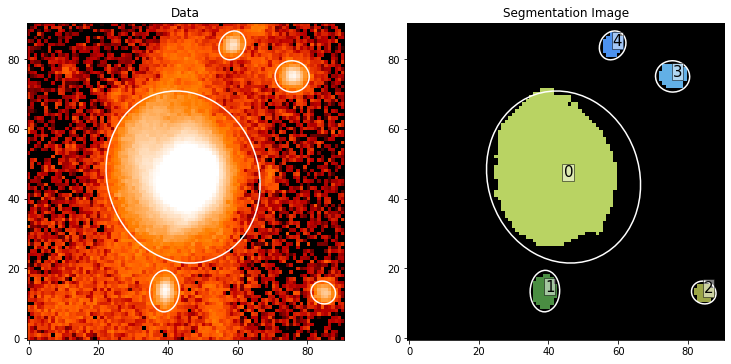

 id xcentroid ycentroid source_sum     orientation      area 
       pix       pix                       deg          pix2 
--- --------- --------- ---------- ------------------- ------
  2     39.00     13.48   39.10329   87.77236234356201   55.0
  1     84.59     13.07  13.751218 -24.085186317078318   25.0
  0     44.35     46.22  2993.7607  -70.41785834340514 1186.0
  3     75.65     75.10   35.00534  -4.814981924220465   48.0
  4     58.45     84.01  22.033587   58.16094667175275   34.0
Input directly the a obj idx to mask, use space between each id:
2
The data_process is ready to go to pass to FittingSpecify!


In [9]:
from decomprofile.data_process import DataProcess
image_RA = 214.156021
image_DEC = 0.564521
data_process = DataProcess(fov_image = fov_image, fov_noise_map = err_data, target_pos = [image_RA, image_DEC],
                           pos_type = 'wcs', header = header,
                          rm_bkglight = False, if_plot=False, zp = zp)

#Manually input the fov noise map:
data_process.fov_noise_map = err_data

#Generate the fitting materials
data_process.generate_target_materials(radius=45, create_mask = True, nsigma=2.8,
                                      exp_sz= 1.2, npixels = 15, if_plot=False)

#Manually input the PSF:
data_process.PSF_list = [PSF]

#Check if all the materials is given, if so to pass to the next step.
data_process.checkout() #Check if all the materials is known.

In [10]:
#%%Start to produce the class and params for lens fitting.
from decomprofile.fitting_specify import FittingSpeficy
fit_sepc = FittingSpeficy(data_process)
fit_sepc.prepare_fitting_seq(point_source_num = 2) #point_source_num =2 for dual AGN.
fit_sepc.build_fitting_seq()

The settings for the fitting is done. Ready to pass to FittingProcess. 
	However, please update self.settings manullay if needed.


Computing the PSO ...
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
Max iteration reached! Stopping.
-6.25283521807483 reduced X^2 of best position
-25671.014987806215 logL
8211.0 effective number of data points
[] lens result
[{'amp': 1, 'R_sersic': 1.7018746713104544, 'n_sersic': 1.477853939988238, 'e1': -0.08620263932924077, 'e2': -0.03198409758807485, 'center_x': -0.07008840557075267, 'center_y': 0.15379470939363699}, {'amp': 1, 'R_sersic': 0.6343204437707284, 'n_sersic': 4.816256757294562, 'e1': -0.21260687573603668, 'e2': 0.16688712798186894, 'center_x': 1.0071400627227207, 'center_y': -5.296880504591544}, {'amp': 1, 'R_sersic': 0.4595131213389055, 'n_sersic': 2.0969147443266487, 'e1': 0.1835266768737756, 'e2': 0.06709579428382274, 'center_x': -5.163086579238968, 'center_y': 5.081123172387951}, {'amp': 1, 'R_sersic': 0.8105331724279538, 'n_sersic': 2.97058380179182, 'e1': 0.07167613742412354, 'e2': -0.33268416306563425, 'center_x': -2.226616314123188, 'center_y': 6.509576711

100%|██████████| 130/130 [06:29<00:00,  3.00s/it]


Computing the MCMC...
Number of walkers =  280
Burn-in iterations:  100
Sampling iterations (in current run): 130
392.2011749744415 time taken for MCMC sampling
549.679 total time taken for the overall fitting (s)
============ CONGRATULATION, YOUR JOB WAS SUCCESSFUL ================ 
-6.22294452060088 reduced X^2 of all evaluated imaging data combined.
reduced chi^2 of data  0 =  6.222944520600881
Start transfering the Params to fluxs...
8400 MCMC samplers in total, finished translate: 1000
8400 MCMC samplers in total, finished translate: 2000
8400 MCMC samplers in total, finished translate: 3000
8400 MCMC samplers in total, finished translate: 4000
8400 MCMC samplers in total, finished translate: 5000
8400 MCMC samplers in total, finished translate: 6000
8400 MCMC samplers in total, finished translate: 7000
8400 MCMC samplers in total, finished translate: 8000


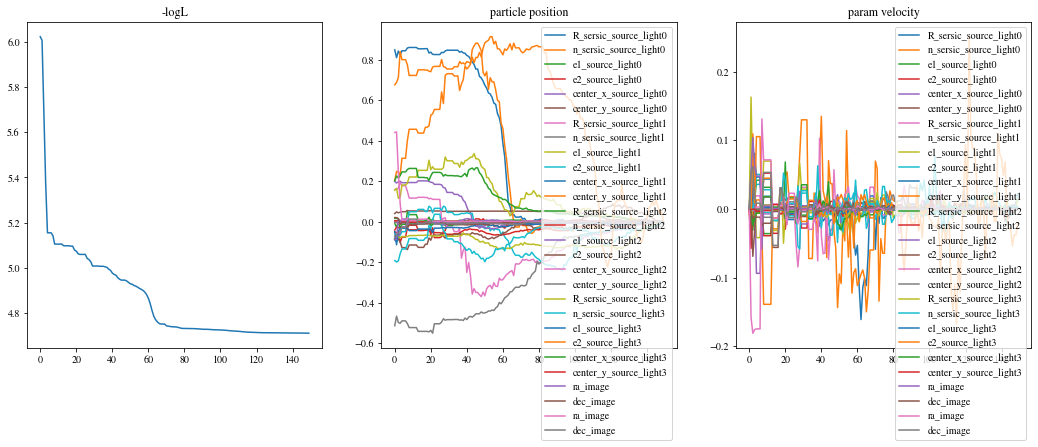

<Figure size 432x288 with 0 Axes>

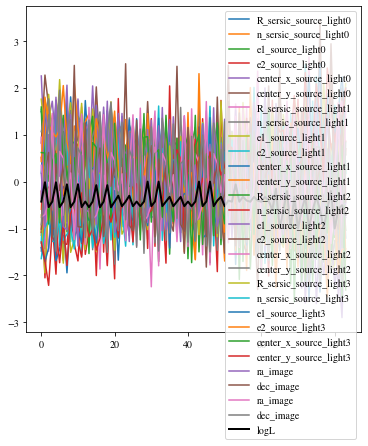

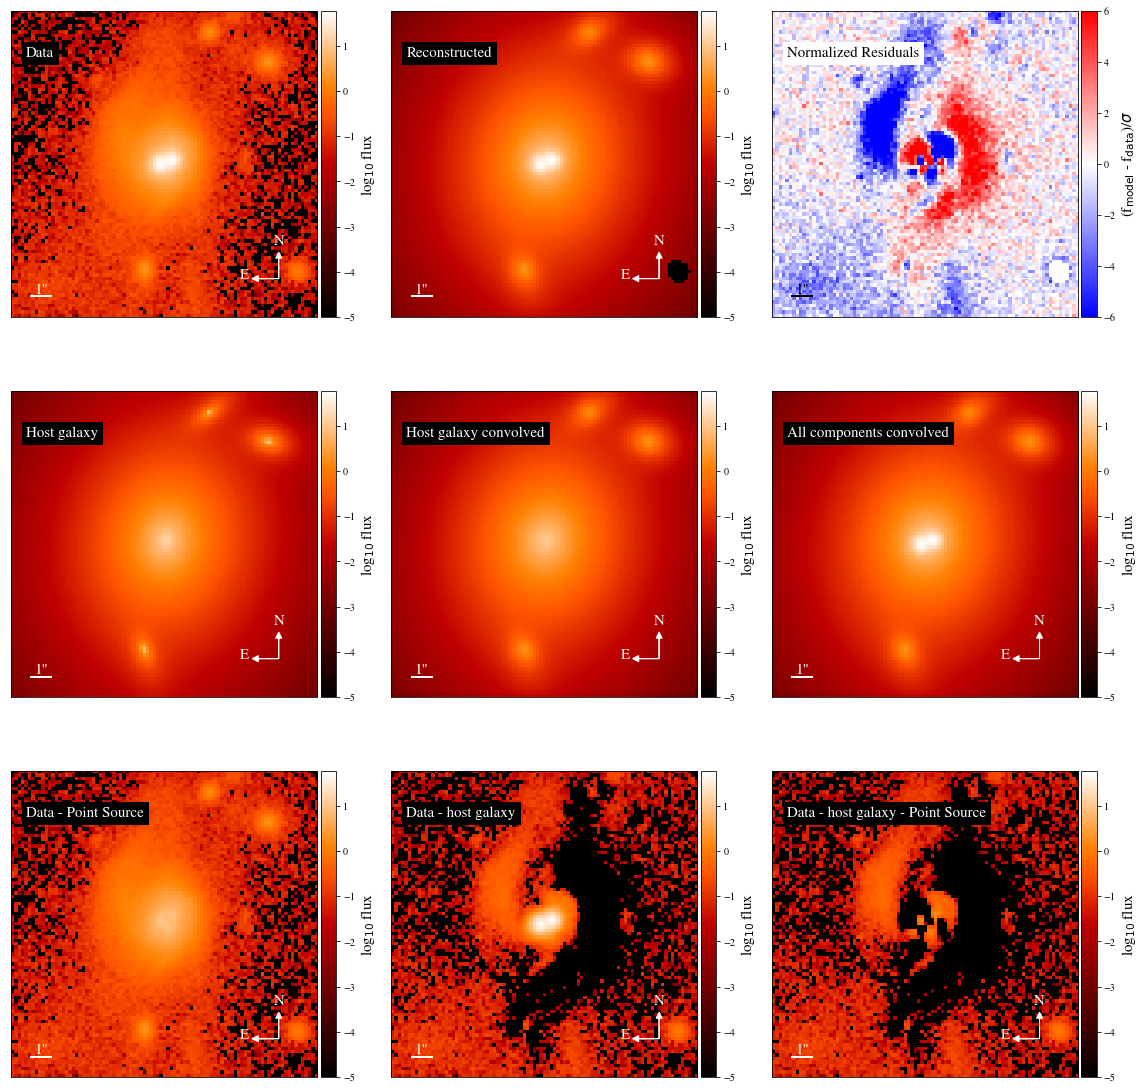

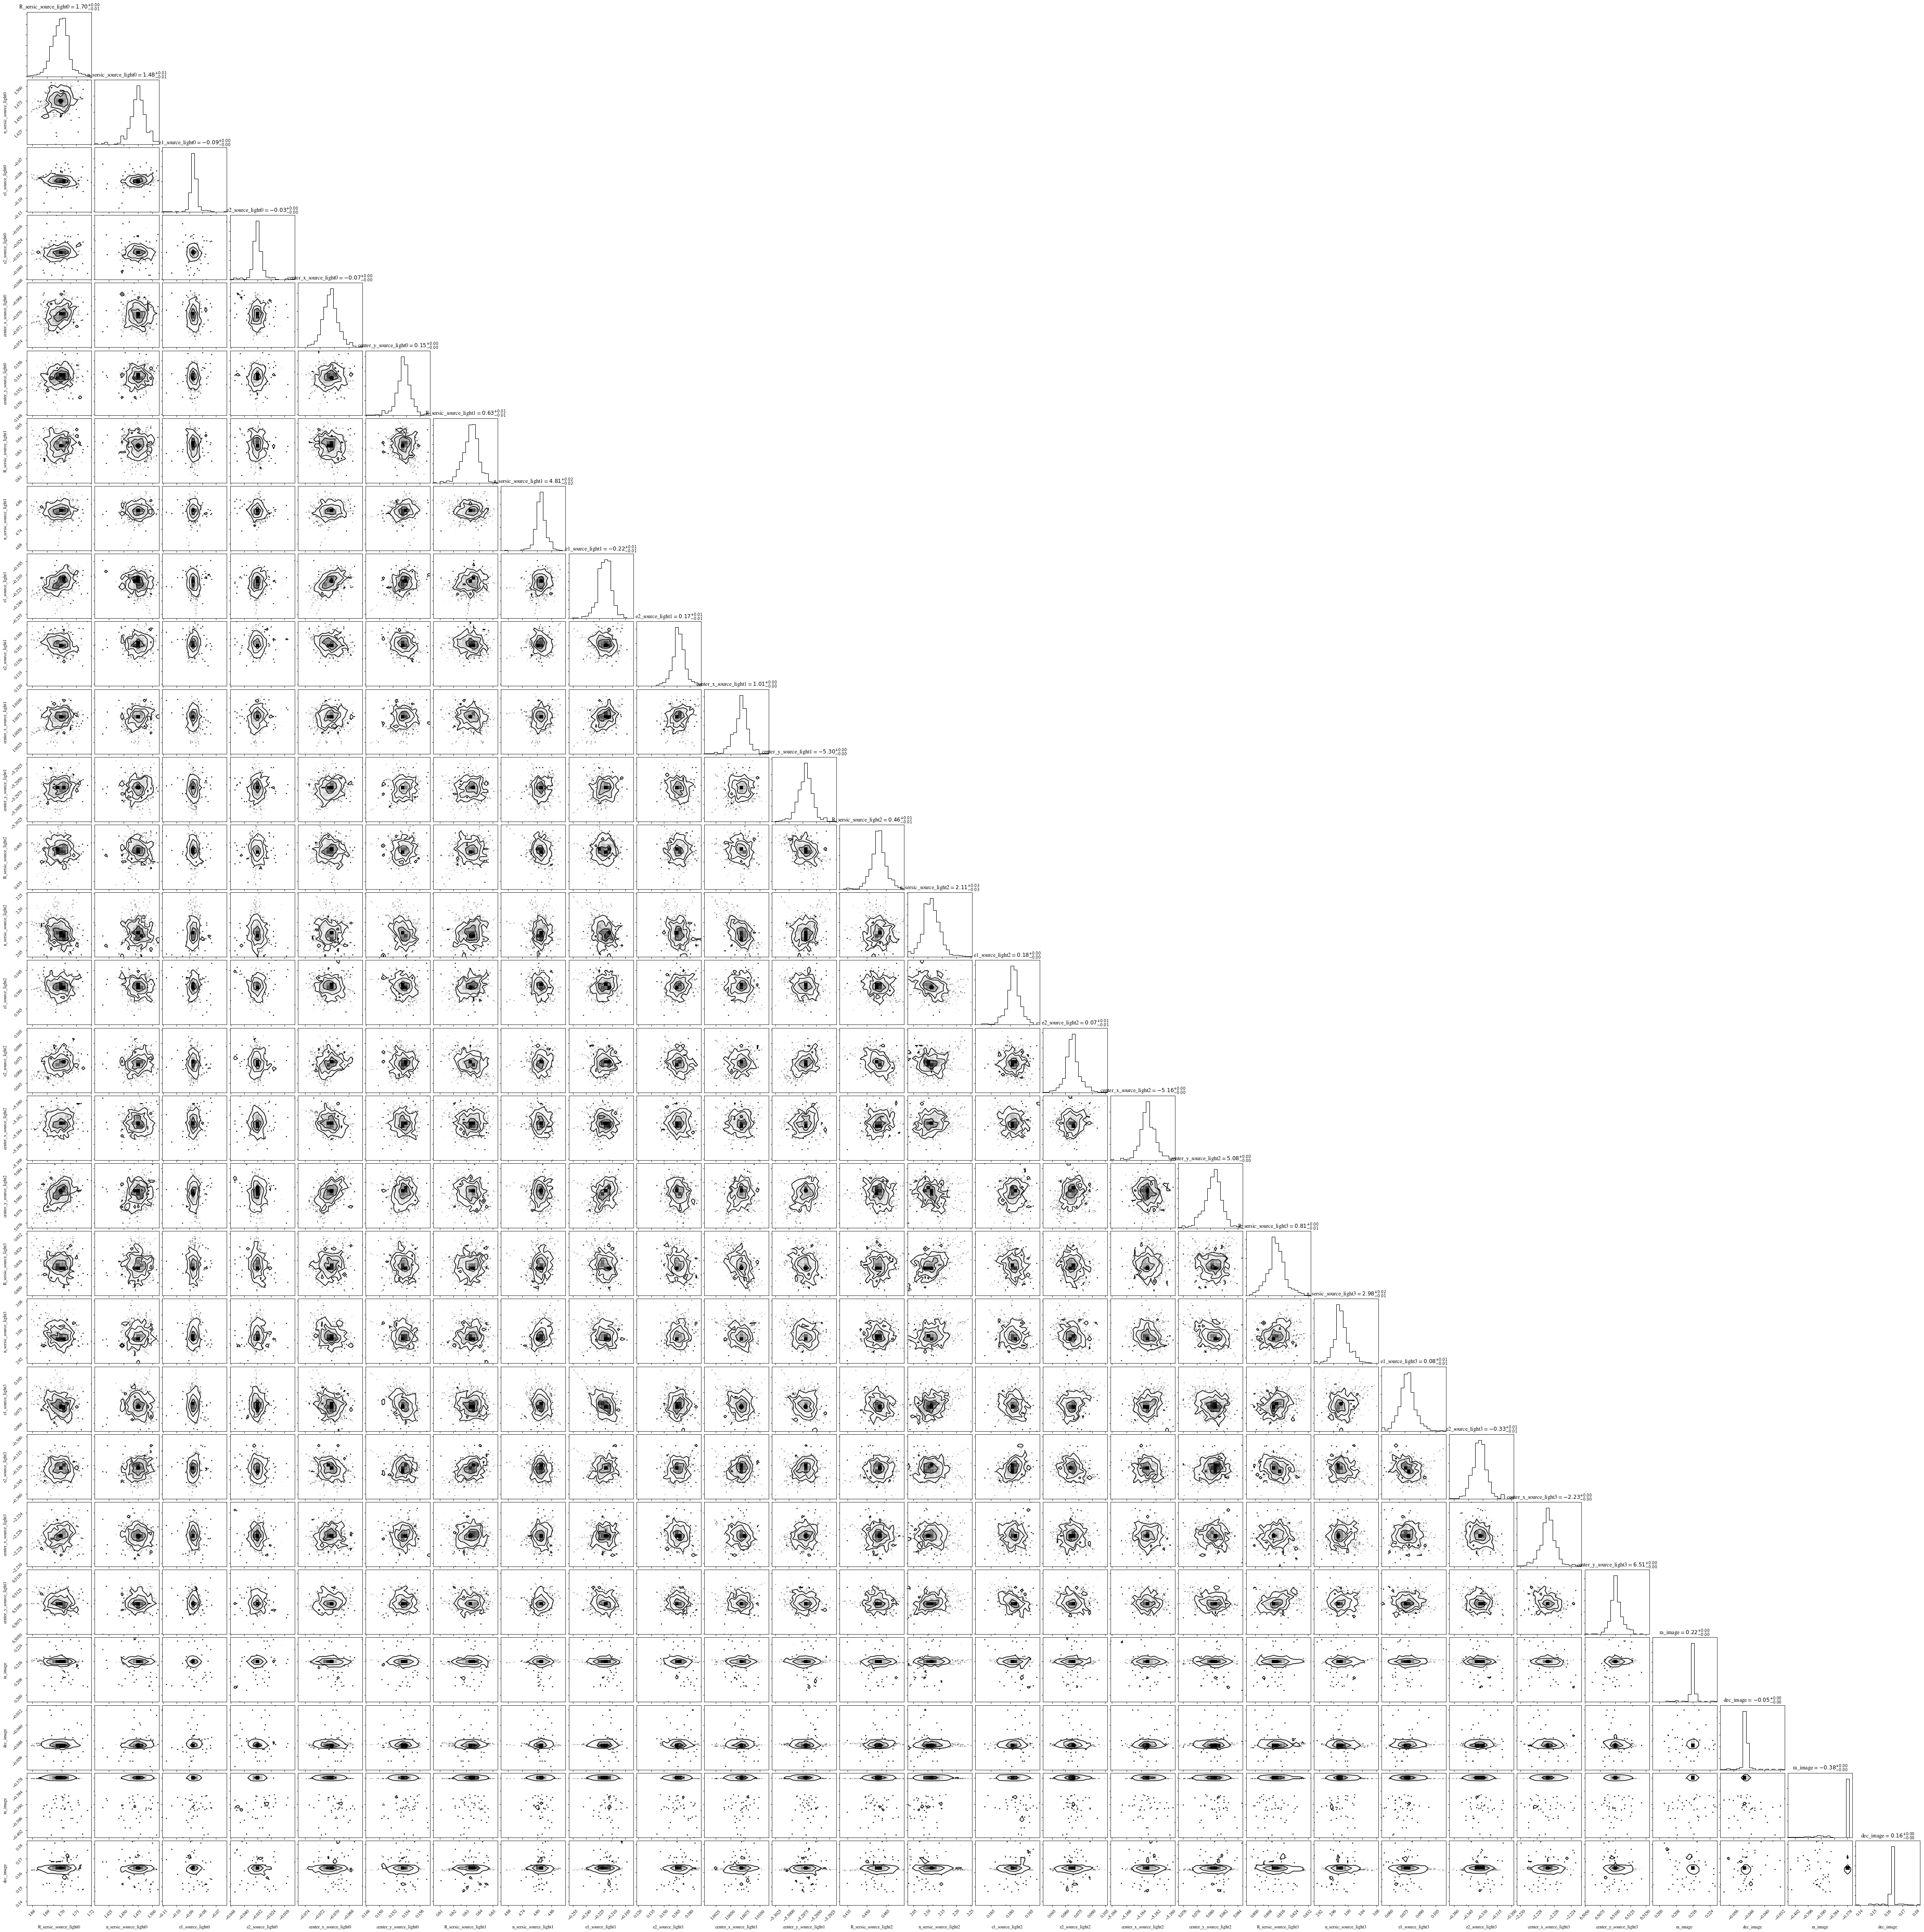

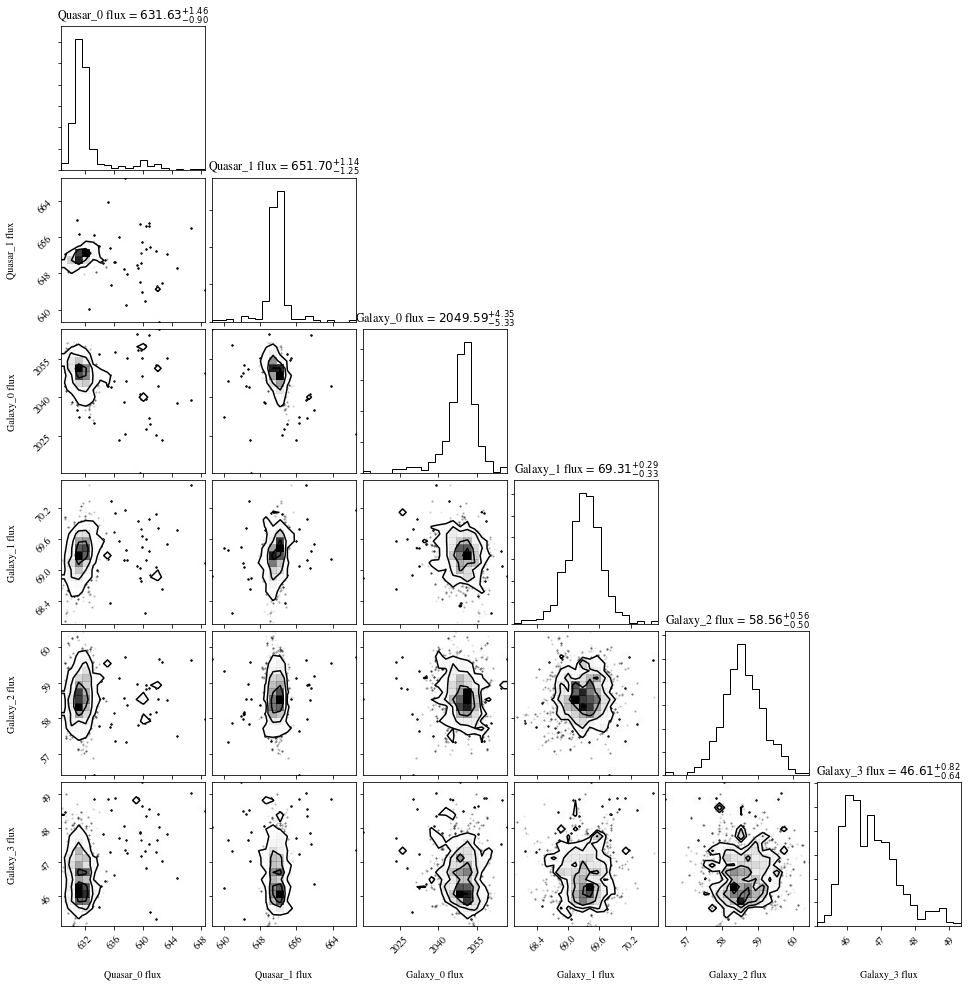

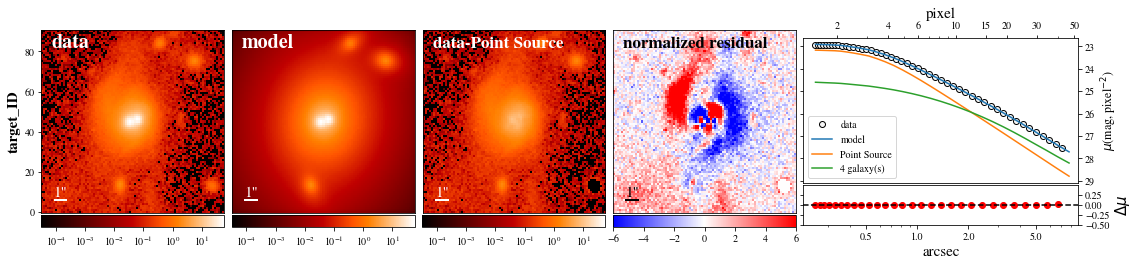

In [11]:
#%%Setting the fitting method and run.
from decomprofile.fitting_process import FittingProcess
fit_run = FittingProcess(fit_sepc, savename = 'HSC_dualAGN')
fit_run.run()
fit_run.plot_all()
fit_run.dump_result()
# # print(fit_run.final_galaxy_result[0])


In [12]:
#Load the saved fitting class, the fitting_run_result would be the loaded as fit_run() in previous fittings.
import pickle
picklename = 'HSC_dualAGN.pkl'
fitting_run_result = pickle.load(open(picklename,'rb'))
#fitting_run_result.plot_final_qso_fit()
fitting_run_result.final_result_galaxy

[{'amp': 60.94632700290228,
  'R_sersic': 1.7042014650721578,
  'n_sersic': 1.4714588775898605,
  'e1': -0.0885184628949822,
  'e2': -0.033793206029481715,
  'center_x': -0.07117484079076163,
  'center_y': 0.1533793068464332,
  'phi_G': -1.3884523493038086,
  'q': 0.8269016777605349,
  'flux_sersic_model': 2074.537619975992,
  'flux_within_frame': 2048.846201708699,
  'magnitude': 18.721226602601376},
 {'amp': 13.807170974105912,
  'R_sersic': 0.6374489631961175,
  'n_sersic': 4.7906595986904,
  'e1': -0.23465693667626714,
  'e2': 0.15619708920693567,
  'center_x': 1.003750050280181,
  'center_y': -5.295022144096971,
  'phi_G': 1.2771505103133995,
  'q': 0.5601974891808099,
  'flux_sersic_model': 77.73306104515983,
  'flux_within_frame': 69.20923131009829,
  'magnitude': 22.399589935835998},
 {'amp': 23.938421469149386,
  'R_sersic': 0.45711233886053,
  'n_sersic': 2.2011961969555656,
  'e1': 0.17710822691581865,
  'e2': 0.08740627626715378,
  'center_x': -5.161424220931382,
  'center_